In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built gast absl-py wrapt termcolor


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [13]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data and do data normalization

In [2]:
df = pd.read_csv('Options.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,cp_flag_C,cp_flag_P,interest_rate
0,AXP,2013-01-02,2013-01-04,2,60.0,0.03,0.181376,58.75,1,0,0.75
1,AXP,2013-01-02,2013-01-04,2,62.5,0.05,0.450289,58.75,1,0,0.75
2,AXP,2013-01-02,2013-01-04,2,65.0,0.05,0.676564,58.75,1,0,0.75
3,AXP,2013-01-02,2013-01-04,2,67.5,0.50,1.369425,58.75,1,0,0.75
4,AXP,2013-01-02,2013-01-04,2,70.0,0.01,0.888123,58.75,1,0,0.75


In [3]:
y = df['best_offer'].values
X = df[['maturity', 'strike_price', 'impl_volatility', 'underlying_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

In [4]:
# Normalize the data to build a regression neural network model
sc= preprocessing.MinMaxScaler()
X= sc.fit_transform(X)
y= y.reshape(-1,1)
y=sc.fit_transform(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(y_train.shape)

(1573351, 7)
(1573351, 1)


In [7]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [8]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

W0623 22:05:10.809075  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 22:05:10.824078  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 22:05:10.831076  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

In [10]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [11]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

W0623 22:05:29.352179  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0623 22:05:38.106596  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0623 22:05:38.246649  8672 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1258680 samples, validate on 314671 samples
Epoch 1/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 1.3830e-04 - rmse: 0.0043 - r_square: 0.9870 - val_loss: 1.5318e-05 - val_rmse: 0.0029 - val_r_square: 0.9985
Epoch 2/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 1.4052e-05 - rmse: 0.0026 - r_square: 0.9986 - val_loss: 8.2428e-06 - val_rmse: 0.0020 - val_r_square: 0.9992
Epoch 3/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 1.1143e-05 - rmse: 0.0023 - r_square: 0.9989 - val_loss: 1.2821e-05 - val_rmse: 0.0025 - val_r_square: 0.9987
Epoch 4/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 9.3023e-06 - rmse: 0.0020 - r_square: 0.9991 - val_loss: 7.1806e-06 - val_rmse: 0.0018 - val_r_square: 0.9993
Epoch 5/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 8.2399e-06 - rmse: 0.0018 - r_square: 0.9992 - val_loss: 6.4446e-06 - val_rmse: 0.0017 - val

1258680/1258680 [==============================] - 6s 5us/step - loss: 4.7693e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 4.5705e-06 - val_rmse: 0.0013 - val_r_square: 0.9996
Epoch 44/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.7890e-06 - rmse: 0.0013 - r_square: 0.9995 - val_loss: 7.8233e-06 - val_rmse: 0.0017 - val_r_square: 0.9992
Epoch 45/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.7232e-06 - rmse: 0.0012 - r_square: 0.9995 - val_loss: 4.4057e-06 - val_rmse: 0.0012 - val_r_square: 0.9996
Epoch 46/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.7465e-06 - rmse: 0.0012 - r_square: 0.9995 - val_loss: 4.0438e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 47/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.6876e-06 - rmse: 0.0012 - r_square: 0.9995 - val_loss: 5.5125e-06 - val_rmse: 0.0015 - val_r_square: 0.9995
Epoch 48/200
1258680/1258680 [=============

1258680/1258680 [==============================] - 6s 5us/step - loss: 4.4064e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 6.3234e-06 - val_rmse: 0.0014 - val_r_square: 0.9994
Epoch 86/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.3737e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 5.4009e-06 - val_rmse: 0.0013 - val_r_square: 0.9995
Epoch 87/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.4058e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.6583e-06 - val_rmse: 0.0013 - val_r_square: 0.9995
Epoch 88/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.3975e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 5.2906e-06 - val_rmse: 0.0013 - val_r_square: 0.9995
Epoch 89/200
1258680/1258680 [==============================] - 6s 5us/step - loss: 4.3923e-06 - rmse: 0.0012 - r_square: 0.9996 - val_loss: 4.0675e-06 - val_rmse: 0.0011 - val_r_square: 0.9996
Epoch 90/200
1258680/1258680 [=============

In [24]:
model.save_weights('model.h5')

In [13]:
predictions = model.predict(X_test)
print(predictions[:10])

[[0.05547181]
 [0.00232244]
 [0.00163608]
 [0.08015914]
 [0.02986703]
 [0.000429  ]
 [0.00038146]
 [0.11281534]
 [0.00167163]
 [0.00037305]]


In [19]:
y_test[:10]

array([[0.05267722],
       [0.00354072],
       [0.00187875],
       [0.07471638],
       [0.03136065],
       [0.0003613 ],
       [0.00028904],
       [0.11337524],
       [0.00122841],
       [0.00050582]])

## Plot learning curves including R^2 and RMSE

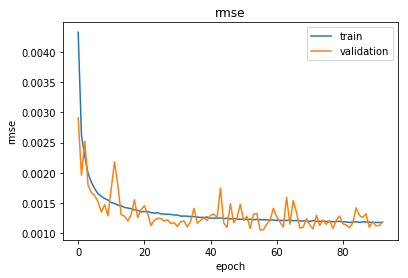

In [14]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

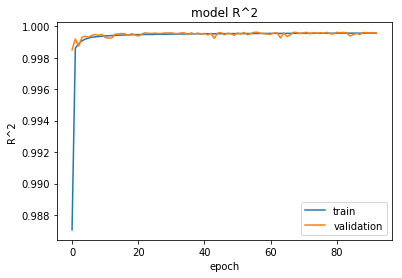

In [15]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [16]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions))



Mean absolute error (MAE):      0.001187
Mean squared error (MSE):       0.000005
Root mean squared error (RMSE): 0.002136
R square (R^2):                 0.999570


## Try dropout

In [17]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model2.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result2 = model2.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0623 22:18:30.824930  8672 deprecation.py:506] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 1258680 samples, validate on 314671 samples
Epoch 1/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 3.1370e-04 - rmse: 0.0083 - r_square: 0.9698 - val_loss: 1.7105e-04 - val_rmse: 0.0069 - val_r_square: 0.9840
Epoch 2/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 3.1086e-05 - rmse: 0.0035 - r_square: 0.9970 - val_loss: 2.2764e-04 - val_rmse: 0.0075 - val_r_square: 0.9787
Epoch 3/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 2.0675e-05 - rmse: 0.0028 - r_square: 0.9980 - val_loss: 1.7900e-04 - val_rmse: 0.0068 - val_r_square: 0.9833
Epoch 4/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 1.6610e-05 - rmse: 0.0025 - r_square: 0.9984 - val_loss: 1.5037e-04 - val_rmse: 0.0072 - val_r_square: 0.9859
Epoch 5/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 1.4679e-05 - rmse: 0.0023 - r_square: 0.9986 - val_loss: 1.6876e-04 - val_rmse: 0.0074 - val

In [18]:
predictions2 = model2.predict(X_test)
print(predictions2[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions2))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions2))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions2)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions2))

[[0.04707419]
 [0.01022818]
 [0.00748053]
 [0.06863838]
 [0.034431  ]
 [0.00056269]
 [0.0017158 ]
 [0.1073888 ]
 [0.00314184]
 [0.0028066 ]]


Mean absolute error (MAE):      0.007355
Mean squared error (MSE):       0.000160
Root mean squared error (RMSE): 0.012660
R square (R^2):                 0.984910


## Try batch normalization technique to regularize neurons

In [19]:
from keras.layers.normalization import BatchNormalization
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 1258680 samples, validate on 314671 samples
Epoch 1/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 3.0125e-04 - rmse: 0.0102 - r_square: 0.9709 - val_loss: 1.1729e-04 - val_rmse: 0.0057 - val_r_square: 0.9887
Epoch 2/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.6909e-04 - rmse: 0.0074 - r_square: 0.9837 - val_loss: 3.1365e-05 - val_rmse: 0.0039 - val_r_square: 0.9969
Epoch 3/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.6013e-04 - rmse: 0.0069 - r_square: 0.9845 - val_loss: 2.0933e-05 - val_rmse: 0.0028 - val_r_square: 0.9980
Epoch 4/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.4954e-04 - rmse: 0.0066 - r_square: 0.9855 - val_loss: 2.8022e-05 - val_rmse: 0.0030 - val_r_square: 0.9973
Epoch 5/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 1.4935e-04 - rmse: 0.0065 - r_square: 0.9855 - val_loss: 3.0421e-05 - val_rmse: 0.0032 - val

1258680/1258680 [==============================] - 7s 6us/step - loss: 1.3083e-04 - rmse: 0.0061 - r_square: 0.9873 - val_loss: 2.0409e-05 - val_rmse: 0.0026 - val_r_square: 0.9981
Epoch 44/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.3274e-04 - rmse: 0.0061 - r_square: 0.9871 - val_loss: 2.4348e-05 - val_rmse: 0.0028 - val_r_square: 0.9977
Epoch 45/200
1258680/1258680 [==============================] - 7s 6us/step - loss: 1.3456e-04 - rmse: 0.0062 - r_square: 0.9870 - val_loss: 2.2158e-05 - val_rmse: 0.0029 - val_r_square: 0.9979
Epoch 46/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.3416e-04 - rmse: 0.0062 - r_square: 0.9871 - val_loss: 1.6966e-05 - val_rmse: 0.0023 - val_r_square: 0.9984
Epoch 47/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.3150e-04 - rmse: 0.0061 - r_square: 0.9873 - val_loss: 2.1001e-05 - val_rmse: 0.0026 - val_r_square: 0.9980
Epoch 48/200
1258680/1258680 [=============

1258680/1258680 [==============================] - 7s 5us/step - loss: 1.3067e-04 - rmse: 0.0061 - r_square: 0.9874 - val_loss: 1.5665e-05 - val_rmse: 0.0022 - val_r_square: 0.9985
Epoch 86/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.2999e-04 - rmse: 0.0061 - r_square: 0.9875 - val_loss: 2.0223e-05 - val_rmse: 0.0024 - val_r_square: 0.9981
Epoch 87/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.2935e-04 - rmse: 0.0061 - r_square: 0.9875 - val_loss: 2.7797e-05 - val_rmse: 0.0030 - val_r_square: 0.9973
Epoch 88/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.2934e-04 - rmse: 0.0060 - r_square: 0.9874 - val_loss: 1.9085e-05 - val_rmse: 0.0028 - val_r_square: 0.9981
Epoch 89/200
1258680/1258680 [==============================] - 7s 5us/step - loss: 1.2984e-04 - rmse: 0.0061 - r_square: 0.9874 - val_loss: 1.6339e-05 - val_rmse: 0.0024 - val_r_square: 0.9984
Epoch 90/200
1258680/1258680 [=============

In [20]:
predictions3 = model3.predict(X_test)
print(predictions3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions3))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions3)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions3))

[[0.05443587]
 [0.00320067]
 [0.00082978]
 [0.0782204 ]
 [0.03396486]
 [0.00061673]
 [0.00061673]
 [0.1019396 ]
 [0.00114214]
 [0.00061673]]


Mean absolute error (MAE):      0.002477
Mean squared error (MSE):       0.000019
Root mean squared error (RMSE): 0.004343
R square (R^2):                 0.998224


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>